In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [3]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i],False)
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [4]:
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i], False)
        y = np.argmax(y_h)
        true_y = np.argmax(Y_test[i])
        if(y == true_y):
            acc += 1.0
    return acc / Y_test.shape[0]

In [5]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))


X_test = test_data['data']

In [6]:
# Подготовка датасета
X = X_train
X = X.astype('float')
Xm = np.mean(X, axis=0)
Xs = np.std(X, axis=0)
X_test_norm = (X_test - Xm) / (Xs + 0.001)
X_train_norm = (X_train - Xm) / (Xs + 0.001)

In [7]:
# делим данные на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train_norm, Y_train_oh, stratify = Y_train)

In [8]:
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2. / in_size)
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)    
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W)   
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx

In [9]:
class ReLU:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.1):
        dz[np.where(self.x < 0)] = 0
        return dz

In [10]:
class Softmax:
    
    def forward(self, x):
        self.x = x
        
        return np.exp(x) / np.sum(np.exp(x))
        
    def backward(self, dz, lr=0.001):
        sigmoid = np.exp(self.x) / np.sum(np.exp(self.x))
        self.lp = (np.eye(self.x.shape[0]) - sigmoid).T
        self.lp2 = sigmoid * self.lp
        
        return np.matmul(dz, self.lp2)

In [11]:
class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        if not self.train:
            self.mask = np.ones(*x.shape) # *x.shape = x.shape[0]
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz, lr=0.001):
        return dz * self.mask

In [12]:
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return (- np.dot(y_true, np.log(y_hat)))
    
    def backward(self, dz, lr=0.001):
        grad = - self.y_true / self.y_hat
        return dz * grad

In [13]:
class MnistNet:
    
    def __init__(self, rlambda=0.0):
        self.d1 = Dense(784, 70, rlambda)
        self.dr = Dropout(0.1)
        self.m1 = ReLU()
        self.d2 = Dense(70, 10, rlambda)
        self.s = Softmax()
        
    def forward(self, x, flag):
        self.dr.set_train(flag)

        net = self.d1.forward(x)
        net = self.dr.forward(net)
        net = self.m1.forward(net)
        net = self.d2.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):

        dz = self.s.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.m1.backward(dz, lr)
        dz = self.dr.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        return dz

In [15]:
import tqdm
net = MnistNet(0.001)
loss = CrossEntropy()
lr = 0.001
L_train = []
L_test = []
for iter in tqdm.tqdm_notebook(range(70)):
    L_acc = 0.
    sh = list(range(x_train.shape[0])) 
    np.random.shuffle(sh)
    for i in range(x_train.shape[0]):
        x = x_train[sh[i]]
        y = y_train[sh[i]]
        y_h = net.forward(x, True)
        L = loss.forward(y, y_h) + net.d1.get_reg_loss() + net.d2.get_reg_loss() 
        L_acc += L 
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    
    L_acc /= y_train.shape[0]
    L_train.append(L_acc)
    L_e_acc = 0.
    
    for i in range(x_test.shape[0]):
        x = x_test[i]
        y = y_test[i]
        y_h = net.forward(x, False)
        L = loss.forward(y, y_h) + net.d1.get_reg_loss() + net.d2.get_reg_loss() 
        L_e_acc += L
    L_e_acc /= y_test.shape[0]
    L_test.append(L_e_acc) 
    

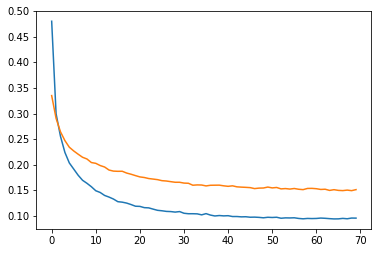

In [16]:
# графики CrossEntropyLoss для обучающей и валидационной выборок
plt.plot(L_train, label='train')
plt.plot(L_test, label='test')

In [17]:
print("Acc: {}".format(compute_acc(x_test, y_test, net)))

Acc: 0.9716571428571429


In [18]:
make_submission(X_test_norm, net, "my_submission.csv")